In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [15]:
path_high_pop = "/kaggle/input/spotify-music-dataset/high_popularity_spotify_data.csv"
path_low_pop = "/kaggle/input/spotify-music-dataset/low_popularity_spotify_data.csv"

In [16]:
df_high = pd.read_csv(path_high_pop)
df_low = pd.read_csv(path_low_pop)
df2 = pd.read_csv("/kaggle/input/-spotify-tracks-dataset/dataset.csv")

In [ ]:
df = pd.concat([df_high, df_low], ignore_index=True)

print(f"Dimensões do spotify-music-dataset: {df.shape[0]} linhas, {df.shape[1]} colunas.")
print("\nColunas disponíveis:", df.columns.tolist())


Dimensões do DataFrame: 4831 linhas, 29 colunas.

Colunas disponíveis: ['energy', 'tempo', 'danceability', 'playlist_genre', 'loudness', 'liveness', 'valence', 'track_artist', 'time_signature', 'speechiness', 'track_popularity', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'instrumentalness', 'track_album_id', 'mode', 'key', 'duration_ms', 'acousticness', 'id', 'playlist_subgenre', 'type', 'playlist_id']


In [ ]:
print(df.shape[0]) # df se refere ao dataset spotify-music-dataset combinado baixa e alta popularidade
print(df2.shape[0]) # df2 se refere ao dataset spotify-tracks-dataset
print(df.columns)
print(df2.columns)

4831
114000
Index(['energy', 'tempo', 'danceability', 'playlist_genre', 'loudness',
       'liveness', 'valence', 'track_artist', 'time_signature', 'speechiness',
       'track_popularity', 'track_href', 'uri', 'track_album_name',
       'playlist_name', 'analysis_url', 'track_id', 'track_name',
       'track_album_release_date', 'instrumentalness', 'track_album_id',
       'mode', 'key', 'duration_ms', 'acousticness', 'id', 'playlist_subgenre',
       'type', 'playlist_id'],
      dtype='object')
Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


In [ ]:
# renomeando colunas em df para consistência
df.rename(columns={
    'track_artist': 'artists',
    'track_album_name': 'album_name',
    'track_popularity': 'popularity',
    'playlist_genre': 'track_genre'
}, inplace=True)

# removendo a coluna 'id' que é redundante com 'track_id'
df.drop(columns=['id'], inplace=True)

# removendo a coluna 'Unnamed: 0' de df2
df2.drop(columns=['Unnamed: 0'], inplace=True)

print("Colunas de 'df' após a preparação:")
print(df.columns.tolist())

Colunas de 'df' após a preparação:
['energy', 'tempo', 'danceability', 'track_genre', 'loudness', 'liveness', 'valence', 'artists', 'time_signature', 'speechiness', 'popularity', 'track_href', 'uri', 'album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'instrumentalness', 'track_album_id', 'mode', 'key', 'duration_ms', 'acousticness', 'playlist_subgenre', 'type', 'playlist_id']


In [20]:
colunas_df = set(df.columns)
colunas_df2 = set(df2.columns)

# encontrar colunas que estão em ambos os sets
colunas_em_comum = list(colunas_df.intersection(colunas_df2))

print(f"Encontradas {len(colunas_em_comum)} colunas em comum.")
print("Elas são:", colunas_em_comum)

Encontradas 19 colunas em comum.
Elas são: ['album_name', 'acousticness', 'tempo', 'track_id', 'track_genre', 'danceability', 'time_signature', 'speechiness', 'popularity', 'liveness', 'track_name', 'mode', 'duration_ms', 'energy', 'instrumentalness', 'artists', 'key', 'loudness', 'valence']


In [21]:
df_filtrado = df[colunas_em_comum]
df2_filtrado = df2[colunas_em_comum]

In [ ]:
# une os dois dataframes, agora que eles têm as mesmas colunas
df_completo = pd.concat([df_filtrado, df2_filtrado], ignore_index=True)
df_completo.drop_duplicates(subset=['track_id'], keep='first', inplace=True)

In [23]:
print(f"\ndim: {df_completo.shape}")
print(f"\n colunas: {df_completo.columns}")


dim: (93574, 19)

 colunas: Index(['album_name', 'acousticness', 'tempo', 'track_id', 'track_genre',
       'danceability', 'time_signature', 'speechiness', 'popularity',
       'liveness', 'track_name', 'mode', 'duration_ms', 'energy',
       'instrumentalness', 'artists', 'key', 'loudness', 'valence'],
      dtype='object')


In [24]:
def map_genres_to_broad_categories(df: pd.DataFrame) -> pd.DataFrame:
    """
    Mapeia os gêneros musicais detalhados da coluna 'track_genre' para categorias amplas,
    retornando um novo DataFrame com a coluna de gênero modificada.

    Args:
        df (pd.DataFrame): O DataFrame de entrada contendo a coluna 'track_genre'.

    Returns:
        pd.DataFrame: Uma cópia do DataFrame com a coluna 'track_genre' atualizada
                      para categorias de gênero amplas. Gêneros não mapeados
                      são agrupados na categoria 'other'.
    """
    if 'track_genre' not in df.columns:
        raise ValueError("O DataFrame precisa conter a coluna 'track_genre'.")

    df_mapped = df.copy()

    category_map = {
        'electronic': ['breakbeat', 'chicago-house', 'club', 'dance', 'dancehall', 'deep-house',
                       'detroit-techno', 'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro',
                       'electronic', 'garage', 'hardstyle', 'house', 'idm', 'minimal-techno',
                       'progressive-house', 'tech-house', 'techno', 'trance', 'trip-hop'],
        'pop': ['pop', 'power-pop', 'indie-pop', 'synth-pop'],
        'hip-hop': ['hip-hop'],
        'rock': ['alt-rock', 'alternative', 'emo', 'goth', 'grunge', 'hard-rock',
                 'psych-rock', 'rock', 'rock-n-roll', 'rockabilly', 'j-rock', 'industrial',
                 'indie'],
        'metal': ['metal', 'black-metal', 'death-metal', 'heavy-metal', 'metalcore', 'grindcore'],
        'punk': ['punk', 'punk-rock', 'hardcore', 'ska'],
        'latin': ['latin', 'latino', 'reggaeton', 'salsa', 'spanish'],
        'brazilian': ['brazil', 'forro', 'mpb', 'pagode', 'samba', 'sertanejo',
                      'brazilian'],
        'world': ['world-music', 'malay', 'turkish', 'iranian', 'british', 'french', 'german', 
                  'swedish', 'indian', 'afrobeat', 'afrobeats', 'arabic', 'world', 'cantopop', 'mandopop',
                  'korean'], 
        'k-pop': ['k-pop'],
        'j-pop': ['j-pop', 'j-idol',
                  'j-dance'], 
        'r-n-b': ['r-n-b', 'r&b', 'soul', 'groove'],
        'jazz': ['jazz'],
        'funk': ['funk'],
        'blues': ['blues'],
        'reggae': ['reggae'],
        'country': ['country', 'bluegrass', 'honky-tonk'],
        'disco': ['disco', 'party'],
        'classical': ['classical', 'opera', 'piano'],
        'folk': ['folk', 'acoustic'],
        'singer-songwriter': ['singer-songwriter', 'songwriter'],
        'soundtrack': ['soundtrack', 'pop-film', 'anime', 'disney',
                       'show-tunes'],
        'instrumental': ['guitar'],
        'ambient': ['ambient', 'chill', 'new-age'],
        'gaming': ['gaming'],
        'lofi': ['lofi'],
        'children': ['children', 'kids'],
        'comedy': ['comedy'],
        'gospel': ['gospel'],
        'wellness': ['romance', 'sad', 'sleep', 'study', 'happy', 'wellness'],
        'tango': ['tango'],
        'soca': ['soca']
    }

    genre_mapping = {subgenre: category
                     for category, subgenres in category_map.items()
                     for subgenre in subgenres}

    df_mapped['track_genre'] = df_mapped['track_genre'].map(genre_mapping).fillna('other')

    return df_mapped

In [25]:
df_completo = map_genres_to_broad_categories(df_completo)

In [26]:
print(df_completo['track_genre'].value_counts())
print(df_completo.dtypes)

track_genre
electronic           18194
world                11302
rock                  8906
brazilian             5156
metal                 4847
wellness              4533
soundtrack            3696
latin                 3504
ambient               3238
pop                   3159
country               2926
classical             2613
j-pop                 2508
punk                  2419
children              1960
folk                  1894
disco                 1740
r-n-b                 1644
hip-hop               1177
blues                 1002
tango                  999
comedy                 990
k-pop                  916
instrumental           884
funk                   781
gospel                 706
jazz                   667
singer-songwriter      520
lofi                   299
reggae                 273
gaming                 107
soca                    14
Name: count, dtype: int64
album_name           object
acousticness        float64
tempo               float64
track_id      

In [27]:
print(f"Tamanho antes do dropna: {df_completo.shape}")
df_sem_na = df_completo.dropna()
print(f"Tamanho depois do dropna: {df_sem_na.shape}")

Tamanho antes do dropna: (93574, 19)
Tamanho depois do dropna: (93571, 19)


In [ ]:
df_processed = df_sem_na

In [ ]:
print("Olhando a cardinalidade: ")
# fizemos isso para ver se seria viável utilizar o one-hot-encoding
print("Valores únicos e suas contagens para a coluna 'key':")
key_counts = df_processed['key'].value_counts()
print(key_counts)
print(f"\n Qt de ocorrencias'key': {df_processed['key'].nunique()}")
print("-" * 50)

print("Valores únicos e suas contagens para a coluna 'time_signature':")
time_signature_counts = df_processed['time_signature'].value_counts()
print(time_signature_counts)
print(f"\n Qt de ocorrencias em 'time_signature': {df_processed['time_signature'].nunique()}")
print("-" * 50)

print("Valores únicos e suas contagens para a coluna 'track_genre':")
playlist_genre_counts = df_processed['track_genre'].value_counts()
print(playlist_genre_counts)
print(f"\nQt de ocorrencias em 'playlist_genre': {df_processed['track_genre'].nunique()}")
print("-" * 50)

dando olhada na cardinalidade
Valores únicos e suas contagens para a coluna 'key':
key
7.0     10939
0.0     10762
2.0      9693
9.0      9335
1.0      9038
5.0      7630
11.0     7445
4.0      7412
6.0      6446
10.0     6145
8.0      5823
3.0      2905
Name: count, dtype: int64

 Qt de ocorrencias'key': 12
--------------------------------------------------
Valores únicos e suas contagens para a coluna 'time_signature':
time_signature
4.0    82929
3.0     7887
5.0     1719
1.0      876
0.0      162
Name: count, dtype: int64

 Qt de ocorrencias em 'time_signature': 5
--------------------------------------------------
Valores únicos e suas contagens para a coluna 'track_genre':
track_genre
electronic           18194
world                11302
rock                  8906
brazilian             5156
metal                 4847
wellness              4533
soundtrack            3696
latin                 3504
ambient               3238
pop                   3159
country               2926
class

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


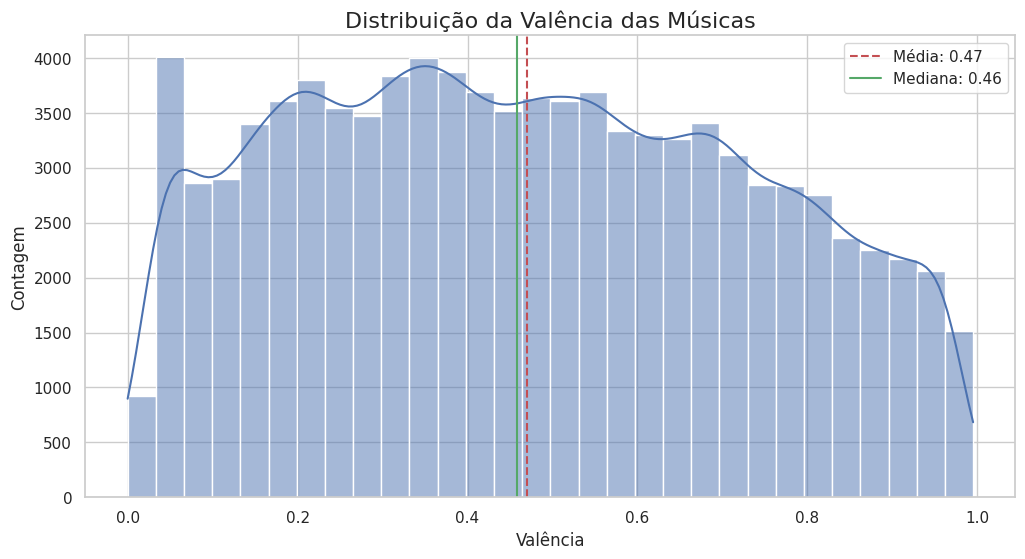

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df_processed['valence'], kde=True, bins=30)
plt.axvline(df_processed['valence'].mean(), color='r', linestyle='--', label=f'Média: {df_processed["valence"].mean():.2f}')

plt.axvline(df_processed['valence'].median(), color='g', linestyle='-', label=f'Mediana: {df_processed["valence"].median():.2f}')

plt.title('Distribuição da Valência das Músicas', fontsize=16)
plt.xlabel('Valência', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.legend()
plt.show()
# gráfico gerado para verificar a questão "Distribuição muito assimétrica (skewed) da variável alvo"
# estamos vendo se a variável alvo está sendo bem distribuída

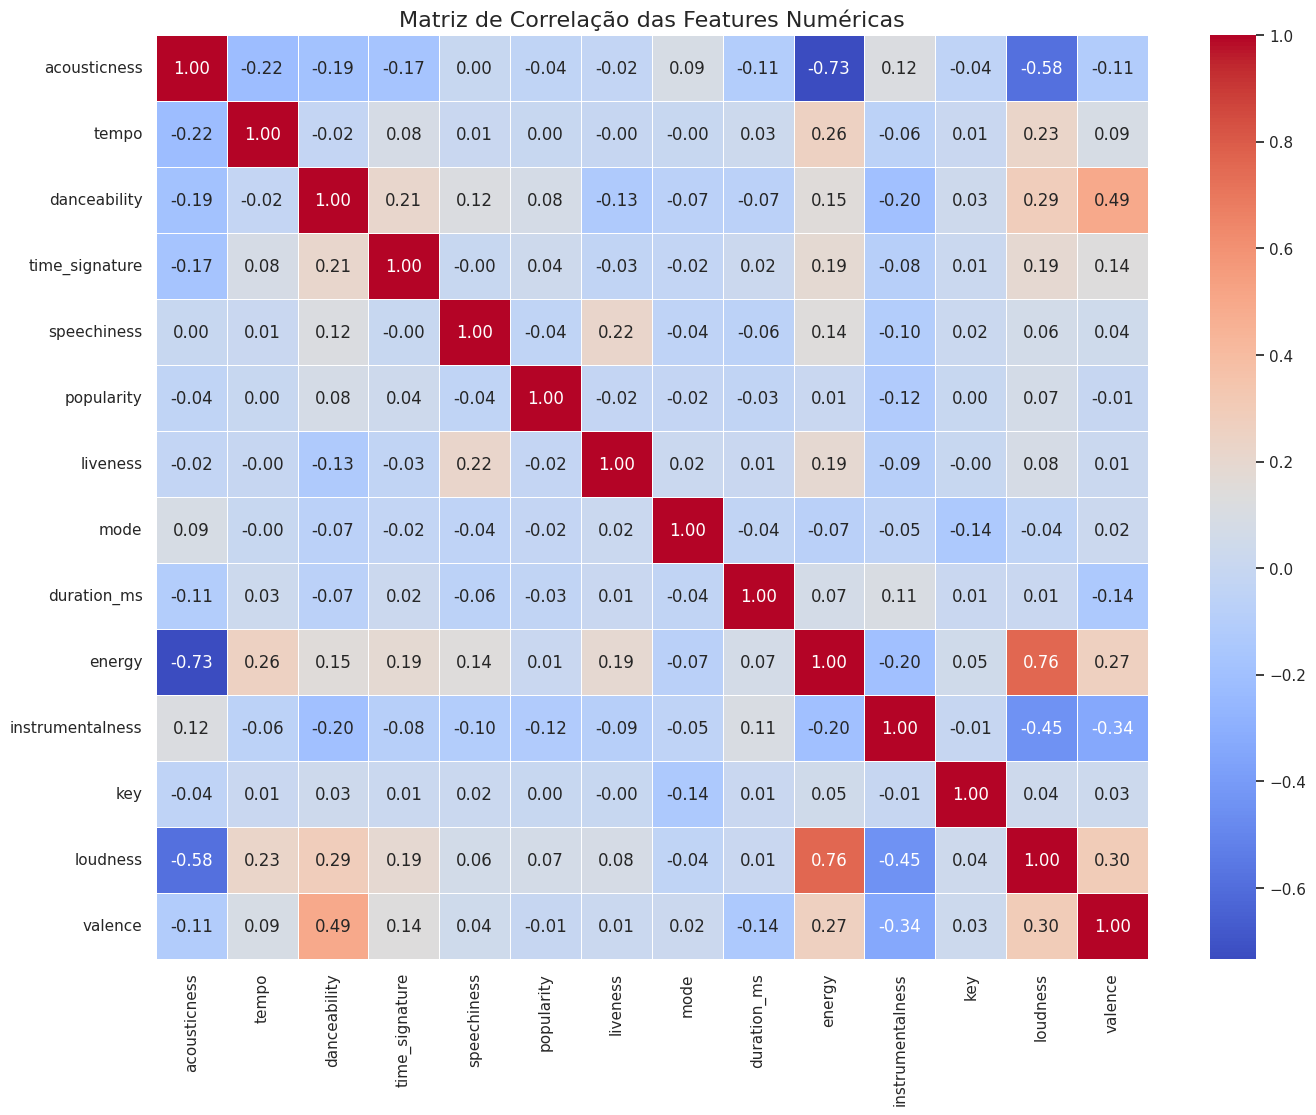


Correlação das features com 'valence':
valence             1.000000
danceability        0.493795
loudness            0.299764
energy              0.266262
time_signature      0.135540
tempo               0.090960
speechiness         0.038560
key                 0.027271
mode                0.020546
liveness            0.013516
popularity         -0.007511
acousticness       -0.114214
duration_ms        -0.143349
instrumentalness   -0.335404
Name: valence, dtype: float64
Índice de 'Previsibilidade' (Soma das Correlações Absolutas):
loudness            3.090246
energy              3.083501
acousticness        2.433687
danceability        2.049975
valence             1.986693
instrumentalness    1.923380
time_signature      1.191773
tempo               1.007091
speechiness         0.851827
liveness            0.832760
duration_ms         0.699576
mode                0.626059
popularity          0.480314
key                 0.397664
dtype: float64


In [ ]:
# seleciona apenas as colunas numéricas para a correlação
numeric_cols = df_processed.select_dtypes(include=np.number).columns

# calcula a matriz de correlação
correlation_matrix = df_processed[numeric_cols].corr()

# plota o heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Features Numéricas', fontsize=16)
plt.show()

# veja especificamente a correlação com a 'valence'
print("\nCorrelação das features com 'valence':")
print(correlation_matrix['valence'].sort_values(ascending=False))
predictability_score = correlation_matrix.abs().sum() - 1

# ordena para ver as mais "previsíveis" no topo
print("Índice de 'Previsibilidade' (Soma das Correlações Absolutas):")
print(predictability_score.sort_values(ascending=False))

In [33]:
categorical_cols = ['track_genre', 'key', 'time_signature']
for col in categorical_cols:
    df_processed[col] = df_processed[col].astype('object')

df_processed = pd.get_dummies(df_processed, columns=categorical_cols, prefix=categorical_cols)

print("DataFrame após o One-Hot Encoding refinado:")
display(df_processed.head())


DataFrame após o One-Hot Encoding refinado:


,album_name,acousticness,tempo,track_id,danceability,speechiness,popularity,liveness,track_name,mode,...,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,Die With A Smile,0.3080,157.969,2plbrEY59IikOBgBGLjaoe,0.521,0.0304,100,0.122,Die With A Smile,0.0,...,False,False,False,False,False,False,False,True,False,False
1,HIT ME HARD AND SOFT,0.2000,104.978,6dOtVTDdiauQNBQEDOtlAB,0.747,0.0358,97,0.117,BIRDS OF A FEATHER,1.0,...,False,False,False,False,False,False,False,False,True,False
2,The Secret of Us (Deluxe),0.2140,108.548,7ne4VBA60CxGM75vw0EYad,0.554,0.0368,93,0.159,That’s So True,1.0,...,False,False,False,False,False,False,False,False,True,False
3,Short n' Sweet,0.0939,112.966,1d7Ptw3qYcfpdLNL5REhtJ,0.670,0.0634,81,0.304,Taste,0.0,...,False,False,False,False,False,False,False,False,True,False
4,APT.,0.0283,149.027,5vNRhkKd0yEAg8suGBpjeY,0.777,0.2600,98,0.355,APT.,0.0,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
print("Verificando os tipos de dados do DataFrame 'df_processed':")
print(df_processed.dtypes)

print("-" * 50)

# filtra e mostra apenas as colunas que NÃO são numéricas
colunas_de_texto = df_processed.select_dtypes(include=['object']).columns.tolist()


print("Colunas de texto encontradas a serem removidas:")
print(colunas_de_texto)

In [ ]:
print("Removendo colunas de texto/ID que não são features: ")
cols_to_drop_final = ['track_id', 'artists', 'album_name', 'track_name'] 

# usamos .select_dtypes para garantir que só fiquem colunas numéricas (int, float, bool), isso remove automaticamente qualquer coluna de texto que tenha sobrado
df_model = df_processed.select_dtypes(include=np.number)

Removendo colunas de texto/ID que não são features...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


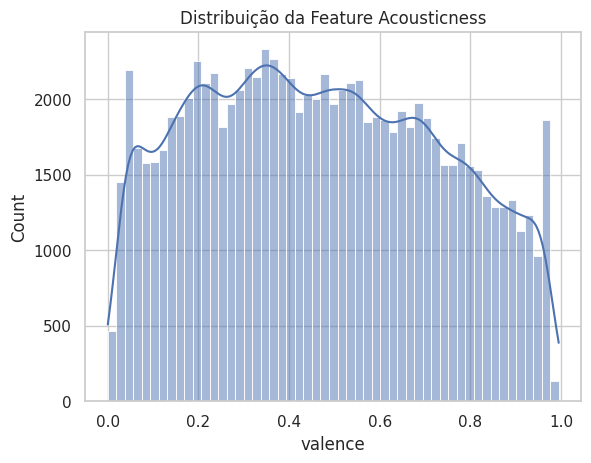

In [36]:
sns.histplot(data=df_model, x='valence', kde=True)
plt.title('Distribuição da Feature Acousticness')
plt.show()

In [ ]:
# calcula a mediana da coluna 'valence'
median_valence = df_model['valence'].median()

# imprime o threshold que será usado 
print(f"O threshold definido pela mediana para 'valence' é: {median_valence:.4f}")

# cria a nova coluna de classe binária 'valence_class'
df_model['valence_class'] = (df_model['valence'] > median_valence).astype(int)

# verifica a contagem de classes na nova coluna
print("\nContagem de cada classe para VALÊNCIA:")
print(df_model['valence_class'].value_counts(normalize=True))

O threshold definido pela mediana para 'valence' é: 0.4580

Contagem de cada classe para VALÊNCIA:
valence_class
0    0.500075
1    0.499925
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [38]:
df_pre_split = df_model.copy()
df_pre_split.describe()

,acousticness,tempo,danceability,speechiness,popularity,liveness,mode,duration_ms,energy,instrumentalness,loudness,valence,valence_class
count,93573.000000,93573.000000,93573.000000,93573.000000,93574.000000,93573.000000,93573.000000,9.357300e+04,93573.000000,93573.000000,93573.000000,93573.000000,93574.000000
mean,0.330028,121.892309,0.564663,0.088103,33.873074,0.214921,0.633890,2.280024e+05,0.631595,0.175904,-8.553366,0.469653,0.499925
std,0.338178,30.078351,0.177816,0.112906,20.759244,0.192739,0.481743,1.120620e+05,0.256774,0.326175,5.344388,0.262803,0.500003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-49.531000,0.000000,0.000000
25%,0.018400,99.024000,0.452000,0.036100,20.000000,0.098100,0.000000,1.720350e+05,0.455000,0.000000,-10.349000,0.249000,0.000000
50%,0.191000,121.991000,0.579000,0.049200,34.000000,0.131000,1.000000,2.122400e+05,0.673000,0.000061,-7.200000,0.458000,0.000000
75%,0.626000,140.051000,0.696000,0.087100,49.000000,0.275000,1.000000,2.627070e+05,0.849000,0.104000,-5.126000,0.683000,1.000000
max,0.996000,243.372000,0.985000,0.965000,100.000000,1.000000,1.000000,5.237295e+06,1.000000,1.000000,4.532000,0.995000,1.000000


In [39]:
print(df_pre_split.isnull().sum())
print(df_pre_split.shape)
df_pre_split = df_pre_split.dropna()
print(df_pre_split.shape)

acousticness        1
tempo               1
danceability        1
speechiness         1
popularity          0
liveness            1
mode                1
duration_ms         1
energy              1
instrumentalness    1
loudness            1
valence             1
valence_class       0
dtype: int64
(93574, 13)
(93573, 13)


In [40]:
df_pre_split['valence_multiclass'] = pd.qcut(df_pre_split['valence'],
                                               q=3,
                                               labels=[0, 1, 2])
print("Contagem de cada classe (Baixa, Média, Alta Valência):")
print(df_pre_split['valence_multiclass'].value_counts(normalize=True))

Contagem de cada classe (Baixa, Média, Alta Valência):
valence_multiclass
0    0.334359
2    0.332970
1    0.332671
Name: proportion, dtype: float64


In [41]:
X = df_pre_split.drop(columns=['valence', 'valence_multiclass', 'valence_class'])
y = df_pre_split['valence_multiclass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [42]:
print(X.columns)

Index(['acousticness', 'tempo', 'danceability', 'speechiness', 'popularity',
       'liveness', 'mode', 'duration_ms', 'energy', 'instrumentalness',
       'loudness'],
      dtype='object')


In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDados preparados e escalonados para o problema de 3 classes!")
print("Formato de X_train_scaled:", X_train_scaled.shape)
print("Formato de y_train:", y_train.shape)


Dados preparados e escalonados para o problema de 3 classes!
Formato de X_train_scaled: (74858, 11)
Formato de y_train: (74858,)


### TREINAMENTO

In [44]:
results_list_class = []

In [ ]:
print("--- Treinando Regressão Logística ---")
start_time = time.time()

# define o modelo e o grid de parâmetros a testar
model_lr = LogisticRegression(max_iter=1000, random_state=42)
param_grid_lr = {
    'C': [0.1, 1.0, 10.0, 100.0] # C é o inverso da força de regularização
}

# configura e executa o GridSearchCV, usamos 'accuracy' como métrica de pontuação, pois as classes estão balanceadas
grid_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)

# pega o melhor modelo e faz a predição
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)

# calcula a acurácia
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# guarda os resultados
results_list_class.append({
    'Modelo': 'Regressão Logística',
    'Melhores Parâmetros': grid_lr.best_params_,
    'Acurácia': accuracy_lr,
    'Tempo (s)': time.time() - start_time
})

print(f"Finalizado em {time.time() - start_time:.2f} segundos.")
print(f"Melhores Parâmetros: {grid_lr.best_params_}")
print(f"Acurácia no Teste: {accuracy_lr:.4f}\n")
print("Relatório de Classificação - Regressão Logística:")
print(classification_report(y_test, y_pred_lr, target_names=['Baixa', 'Média', 'Alta']))

--- Treinando Regressão Logística ---
Finalizado em 3.97 segundos.
Melhores Parâmetros: {'C': 10.0}
Acurácia no Teste: 0.5661

Relatório de Classificação - Regressão Logística:
              precision    recall  f1-score   support

       Baixa       0.64      0.64      0.64      6258
       Média       0.45      0.38      0.41      6226
        Alta       0.59      0.68      0.63      6231

    accuracy                           0.57     18715
   macro avg       0.56      0.57      0.56     18715
weighted avg       0.56      0.57      0.56     18715



In [46]:
print("--- Treinando Random Forest Classifier ---")
start_time = time.time()

model_rf_c = RandomForestClassifier(random_state=42)
param_grid_rf_c = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf_c = GridSearchCV(estimator=model_rf_c, param_grid=param_grid_rf_c, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf_c.fit(X_train_scaled, y_train)

best_rf_c = grid_rf_c.best_estimator_
y_pred_rf_c = best_rf_c.predict(X_test_scaled)

accuracy_rf_c = accuracy_score(y_test, y_pred_rf_c)

results_list_class.append({
    'Modelo': 'Random Forest Classifier',
    'Melhores Parâmetros': grid_rf_c.best_params_,
    'Acurácia': accuracy_rf_c,
    'Tempo (s)': time.time() - start_time
})

print(f"Finalizado em {time.time() - start_time:.2f} segundos.")
print(f"Melhores Parâmetros: {grid_rf_c.best_params_}")
print(f"Acurácia no Teste: {accuracy_rf_c:.4f}\n")
print("Relatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf_c, target_names=['Baixa', 'Média', 'Alta']))

--- Treinando Random Forest Classifier ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Finalizado em 899.48 segundos.
Melhores Parâmetros: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}
Acurácia no Teste: 0.6473

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

       Baixa       0.71      0.72      0.71      6258
       Média       0.55      0.49      0.51      6226
        Alta       0.67      0.74      0.70      6231

    accuracy                           0.65     18715
   macro avg       0.64      0.65      0.64     18715
weighted avg       0.64      0.65      0.64     18715



In [47]:
print("--- Treinando Gradient Boosting Classifier ---")
start_time = time.time()

model_gb_c = GradientBoostingClassifier(random_state=42)
param_grid_gb_c = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid_gb_c = GridSearchCV(estimator=model_gb_c, param_grid=param_grid_gb_c, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_gb_c.fit(X_train_scaled, y_train)

best_gb_c = grid_gb_c.best_estimator_
y_pred_gb_c = best_gb_c.predict(X_test_scaled)

accuracy_gb_c = accuracy_score(y_test, y_pred_gb_c)

results_list_class.append({
    'Modelo': 'Gradient Boosting',
    'Melhores Parâmetros': grid_gb_c.best_params_,
    'Acurácia': accuracy_gb_c,
    'Tempo (s)': time.time() - start_time
})

print(f"Finalizado em {time.time() - start_time:.2f} segundos.")
print(f"Melhores Parâmetros: {grid_gb_c.best_params_}")
print(f"Acurácia no Teste: {accuracy_gb_c:.4f}\n")
print("Relatório de Classificação - Gradient Boosting:")
print(classification_report(y_test, y_pred_gb_c, target_names=['Baixa', 'Média', 'Alta']))

--- Treinando Gradient Boosting Classifier ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finalizado em 2067.93 segundos.
Melhores Parâmetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Acurácia no Teste: 0.6285

Relatório de Classificação - Gradient Boosting:
              precision    recall  f1-score   support

       Baixa       0.70      0.69      0.70      6258
       Média       0.51      0.47      0.49      6226
        Alta       0.66      0.72      0.69      6231

    accuracy                           0.63     18715
   macro avg       0.62      0.63      0.63     18715
weighted avg       0.62      0.63      0.63     18715



In [ ]:
print("--- Treinando XGBoost Classifier ---")
start_time = time.time()

# define o modelo, use_label_encoder=False e eval_metric='mlogloss' são adicionados para evitar avisos comuns.
model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# define o grid de parâmetros que queremos testar
param_grid_xgb = {
    'n_estimators': [100, 200],      # número de árvores
    'learning_rate': [0.05, 0.1],     # taxa de aprendizado
    'max_depth': [3, 5],              # profundidade máxima das árvores
    'gamma': [0, 0.1]                 # parâmetro de regularização para evitar overfitting
}

# configura e executa o GridSearchCV para encontrar os melhores parâmetros
grid_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_scaled, y_train)

# pega o melhor modelo encontrado pelo GridSearch
best_xgb = grid_xgb.best_estimator_

# faz a predição no conjunto de teste
y_pred_xgb = best_xgb.predict(X_test_scaled)

# calcula a acurácia final
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# guarda os resultados na nossa lista para a tabela comparativa final
results_list_class.append({
    'Modelo': 'XGBoost Classifier',
    'Melhores Parâmetros': grid_xgb.best_params_,
    'Acurácia': accuracy_xgb,
    'Tempo (s)': time.time() - start_time
})

# imprime os resultados para este modelo
print(f"\nFinalizado em {time.time() - start_time:.2f} segundos.")
print(f"Melhores Parâmetros: {grid_xgb.best_params_}")
print(f"Acurácia no Teste: {accuracy_xgb:.4f}\n")

print("--- Relatório de Classificação - XGBoost ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Baixa', 'Média', 'Alta']))

--- Treinando XGBoost Classifier ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Finalizado em 113.35 segundos.
Melhores Parâmetros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Acurácia no Teste: 0.6250

--- Relatório de Classificação - XGBoost ---
              precision    recall  f1-score   support

       Baixa       0.69      0.69      0.69      6258
       Média       0.51      0.46      0.48      6226
        Alta       0.65      0.72      0.69      6231

    accuracy                           0.62     18715
   macro avg       0.62      0.62      0.62     18715
weighted avg       0.62      0.62      0.62     18715



In [ ]:
# cria um dataframe com os resultados
df_results_class = pd.DataFrame(results_list_class)

# ordena o dataframe pela acurácia (do maior para o menor)
df_results_class_sorted = df_results_class.sort_values(by='Acurácia', ascending=False).reset_index(drop=True)

print("--- TABELA COMPARATIVA DE RESULTADOS - CLASSIFICAÇÃO ---")
display(df_results_class_sorted)

--- TABELA COMPARATIVA DE RESULTADOS - CLASSIFICAÇÃO ---


,Modelo,Melhores Parâmetros,Acurácia,Tempo (s)
0,Random Forest Classifier,"{'max_depth': None, 'min_samples_leaf': 2, 'n_...",0.647288,899.480800
1,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.628480,2067.925381
2,XGBoost Classifier,"{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",0.624953,113.351923
3,Regressão Logística,{'C': 10.0},0.566070,3.973845


In [ ]:
print("--- Análise do Modelo Campeão: Random Forest Classifier ---\n")

# parâmetros otimizados que você encontrou
best_params_rf = {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}

# cria o modelo final com esses parâmetros
final_rf_model = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=42,
    n_jobs=-1 # usa todos os núcleos para treinar mais rápido
)

# treina o modelo final com TODOS os dados de treino
final_rf_model.fit(X_train_scaled, y_train)

# faz as previsões no conjunto de teste
y_pred_final = final_rf_model.predict(X_test_scaled)

--- Análise do Modelo Campeão: Random Forest Classifier ---




--- Matriz de Confusão ---



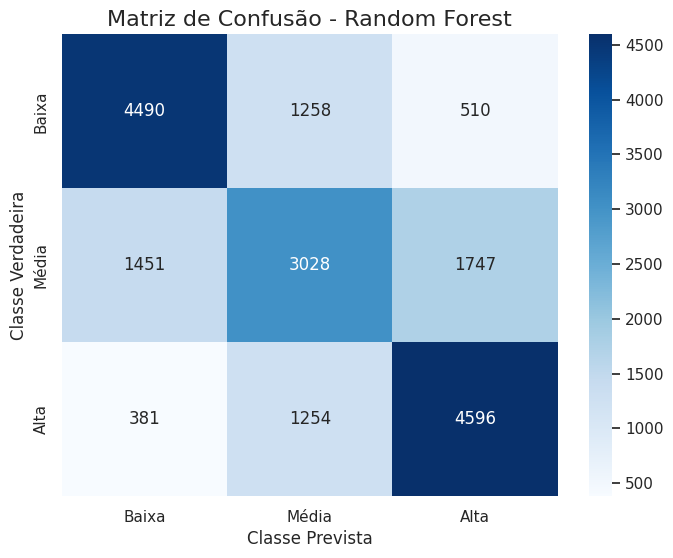

In [51]:
print("\n--- Matriz de Confusão ---\n")
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixa', 'Média', 'Alta'],
            yticklabels=['Baixa', 'Média', 'Alta'])
plt.title('Matriz de Confusão - Random Forest', fontsize=16)
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

As 15 features mais importantes para o modelo:


,Feature,Importance
2,danceability,0.172608
8,energy,0.119170
7,duration_ms,0.095560
9,instrumentalness,0.094494
0,acousticness,0.091181
10,loudness,0.088822
3,speechiness,0.087916
1,tempo,0.085550
5,liveness,0.082136
4,popularity,0.071082


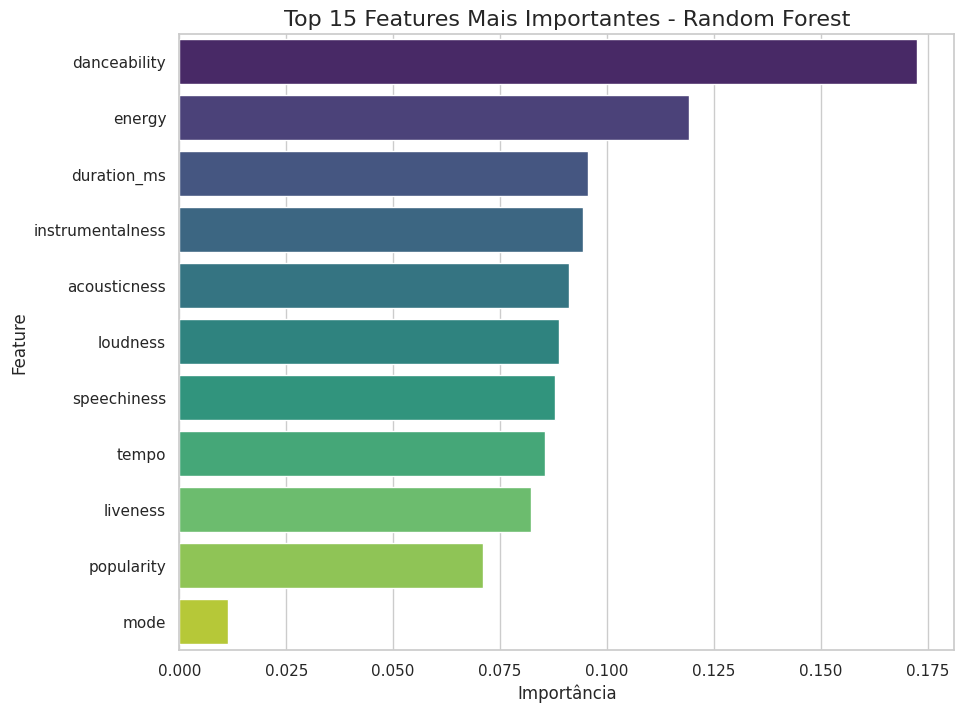

In [ ]:
# extrai a importância de cada feature do modelo treinado
importances = final_rf_model.feature_importances_

# cria um dataframe para visualizar melhor
# 'X.columns' pega o nome de todas as colunas de features antes do escalonamento
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# exibe as features mais importantes
print("As 15 features mais importantes para o modelo:")
display(feature_importance_df.head(15))

# plota um gráfico de barras para visualizar a importância
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Features Mais Importantes - Random Forest', fontsize=16)
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

In [ ]:
print("\n--- Análise dos Erros ---\n")

# cria um dataframe para comparar os resultados verdadeiros com os previstos
df_analysis = pd.DataFrame({'Verdadeiro': y_test, 'Previsto': y_pred_final})

# filtra para ver apenas os erros
df_errors = df_analysis[df_analysis['Verdadeiro'] != df_analysis['Previsto']]

# exemplo: com o que as músicas de valência "Média" (classe 1) são mais confundidas?
medium_errors = df_errors[df_errors['Verdadeiro'] == 1]['Previsto'].value_counts()

print("Análise dos erros da classe 'Média':")
print("Quando o modelo erra uma música de valência Média, ele a classifica como:")
print(medium_errors)


--- Análise dos Erros ---

Análise dos erros da classe 'Média':
Quando o modelo erra uma música de valência Média, ele a classifica como:
Previsto
2    1747
0    1451
Name: count, dtype: int64
